<a href="https://colab.research.google.com/github/PBJ-AI/workbench-example-hybrid-rag/blob/main/class-7/class-7-DiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suggestion is to run with A100 GPU to save time

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")

import math
import keras
import tensorflow as tf

import tensorflow as tf
from keras import (
    layers,
    models,
    optimizers,
    utils,
    callbacks,
    metrics,
    losses,
    activations,
)

In [2]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [8]:
IMAGE_SIZE = 32
BATCH_SIZE = 4
DATASET_REPETITIONS = 5
LOAD_MODEL = False

NOISE_EMBEDDING_SIZE = 32
PLOT_DIFFUSION_STEPS = 20

# optimization
EMA = 0.999
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

In [10]:
train_data = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,
    labels=None,
    shuffle=True,
    interpolation="bilinear",

    )

Found 3670 files.
Using 2936 files for training.


In [11]:
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))
train = train.repeat(DATASET_REPETITIONS)
train = train.batch(BATCH_SIZE, drop_remainder=True)

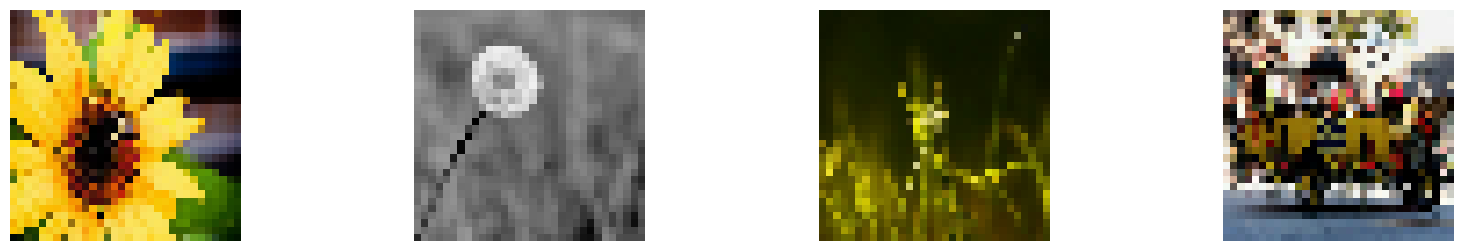

In [13]:
train_sample = sample_batch(train)
display(train_sample, n=BATCH_SIZE)

In [14]:
def linear_diffusion_schedule(diffusion_times):
    min_rate = 0.0001
    max_rate = 0.02
    betas = min_rate + diffusion_times * (max_rate - min_rate)
    alphas = 1 - betas
    alpha_bars = tf.math.cumprod(alphas)
    signal_rates = tf.sqrt(alpha_bars)
    noise_rates = tf.sqrt(1 - alpha_bars)
    return noise_rates, signal_rates

In [15]:
def cosine_diffusion_schedule(diffusion_times):
    signal_rates = tf.cos(diffusion_times * math.pi / 2)
    noise_rates = tf.sin(diffusion_times * math.pi / 2)
    return noise_rates, signal_rates

In [16]:
def offset_cosine_diffusion_schedule(diffusion_times):
    min_signal_rate = 0.02
    max_signal_rate = 0.95
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

In [17]:
T = 1000
diffusion_times = tf.convert_to_tensor([x / T for x in range(T)])
linear_noise_rates, linear_signal_rates = linear_diffusion_schedule(
    diffusion_times
)
cosine_noise_rates, cosine_signal_rates = cosine_diffusion_schedule(
    diffusion_times
)
(
    offset_cosine_noise_rates,
    offset_cosine_signal_rates,
) = offset_cosine_diffusion_schedule(diffusion_times)

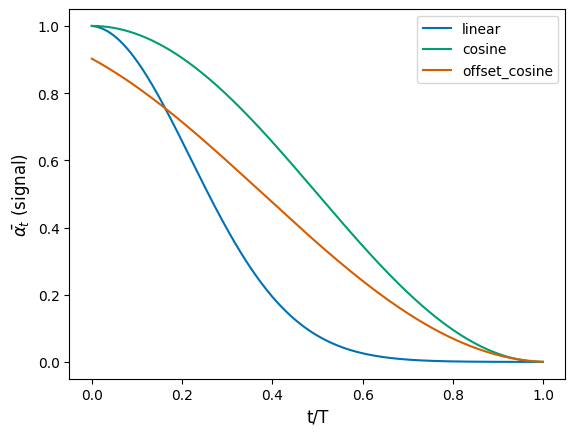

In [18]:
plt.plot(
    diffusion_times, linear_signal_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_signal_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_signal_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$\bar{\alpha_t}$ (signal)", fontsize=12)
plt.legend()
plt.show()

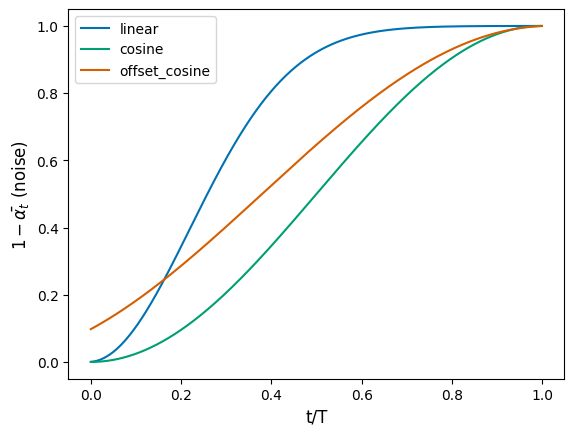

In [19]:
plt.plot(
    diffusion_times, linear_noise_rates**2, linewidth=1.5, label="linear"
)
plt.plot(
    diffusion_times, cosine_noise_rates**2, linewidth=1.5, label="cosine"
)
plt.plot(
    diffusion_times,
    offset_cosine_noise_rates**2,
    linewidth=1.5,
    label="offset_cosine",
)

plt.xlabel("t/T", fontsize=12)
plt.ylabel(r"$1-\bar{\alpha_t}$ (noise)", fontsize=12)
plt.legend()
plt.show()

In [20]:
@keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(1.0),
            tf.math.log(1000.0),
            NOISE_EMBEDDING_SIZE // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

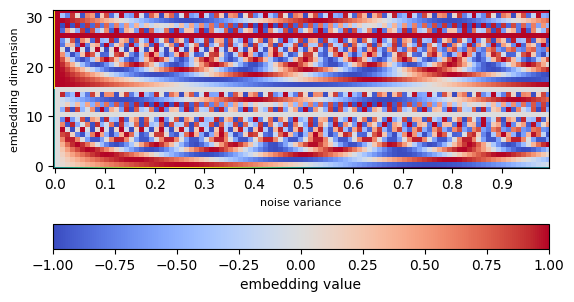

In [21]:
embedding_list = []
for y in np.arange(0, 1, 0.01):
    embedding_list.append(sinusoidal_embedding(np.array([[[[y]]]]))[0][0][0])
embedding_array = np.array(np.transpose(embedding_list))
fig, ax = plt.subplots()
ax.set_xticks(
    np.arange(0, 100, 10), labels=np.round(np.arange(0.0, 1.0, 0.1), 1)
)
ax.set_ylabel("embedding dimension", fontsize=8)
ax.set_xlabel("noise variance", fontsize=8)
plt.pcolor(embedding_array, cmap="coolwarm")
plt.colorbar(orientation="horizontal", label="embedding value")
ax.imshow(embedding_array, interpolation="nearest", origin="lower")
plt.show()

In [22]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [23]:
noisy_images = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = layers.Conv2D(32, kernel_size=1)(noisy_images)

noise_variances = layers.Input(shape=(1, 1, 1))
noise_embedding = layers.Lambda(sinusoidal_embedding)(noise_variances)
noise_embedding = layers.UpSampling2D(size=IMAGE_SIZE, interpolation="nearest")(
    noise_embedding
)

x = layers.Concatenate()([x, noise_embedding])

skips = []

x = DownBlock(32, block_depth=2)([x, skips])
x = DownBlock(64, block_depth=2)([x, skips])
x = DownBlock(96, block_depth=2)([x, skips])

x = ResidualBlock(128)(x)
x = ResidualBlock(128)(x)

x = UpBlock(96, block_depth=2)([x, skips])
x = UpBlock(64, block_depth=2)([x, skips])
x = UpBlock(32, block_depth=2)([x, skips])

x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

unet = models.Model([noisy_images, noise_variances], x, name="unet")

In [24]:
class DiffusionModel(models.Model):
    def __init__(self):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = unet
        self.ema_network = models.clone_model(self.network)
        self.diffusion_schedule = offset_cosine_diffusion_schedule

    def compile(self, **kwargs):
        super().compile(**kwargs)
        self.noise_loss_tracker = metrics.Mean(name="n_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker]

    def denormalize(self, images):
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network(
            [noisy_images, noise_rates**2], training=training
        )
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                current_images, noise_rates, signal_rates, training=False
            )
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            current_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(
                shape=(num_images, IMAGE_SIZE, IMAGE_SIZE, 3)
            )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))

        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        self.noise_loss_tracker.update_state(noise_loss)

        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(EMA * ema_weight + (1 - EMA) * weight)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3))
        diffusion_times = tf.random.uniform(
            shape=(BATCH_SIZE, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )
        noise_loss = self.loss(noises, pred_noises)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

In [25]:
ddm = DiffusionModel()
ddm.normalizer.adapt(train)

In [26]:
if LOAD_MODEL:
    dummy_input = tf.zeros((1, 28, 28, 1))
    ddm(dummy_input)
    ddm.load_weights("/content/checkpoint/checkpoint.ckpt")

In [27]:
ddm.compile(
    optimizer=optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    ),
    loss=losses.mean_absolute_error,
)

In [28]:
!pip install matplotlib

In [29]:
import matplotlib.pyplot as pl

In [30]:
!mkdir /content/output

Epoch 1/20
3668/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.3077
Saved to /content/output/generated_img_000.png


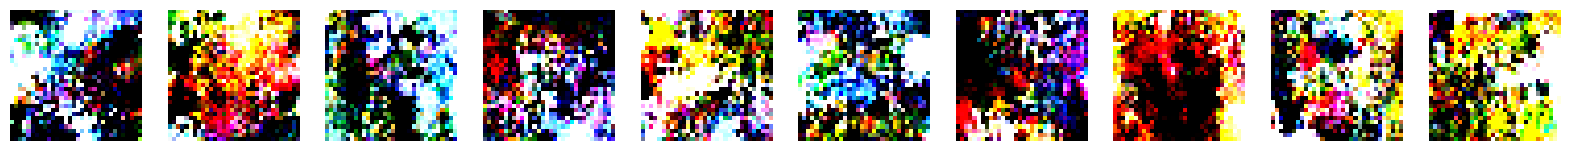

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 78s 12ms/step - n_loss: 0.3077
Epoch 2/20
3669/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2515
Saved to /content/output/generated_img_001.png


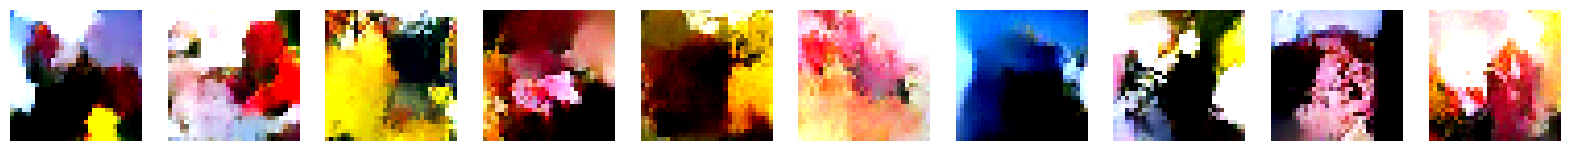

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - n_loss: 0.2515
Epoch 3/20
3669/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2420
Saved to /content/output/generated_img_002.png


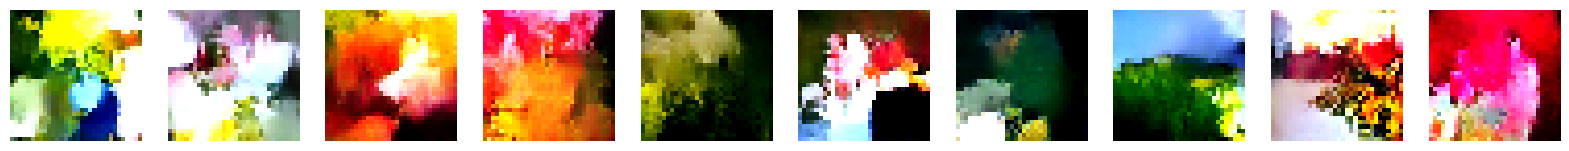

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - n_loss: 0.2420
Epoch 4/20
3666/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2391
Saved to /content/output/generated_img_003.png


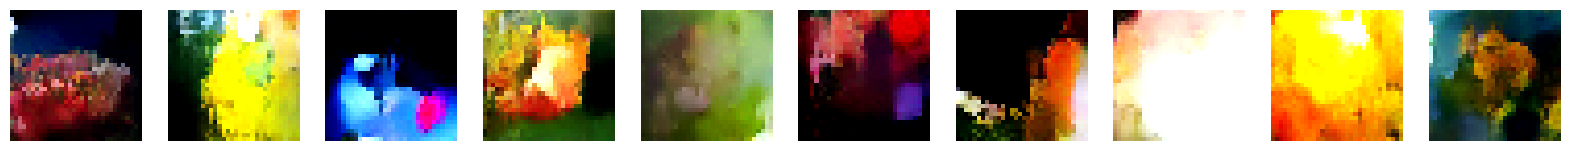

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2391
Epoch 5/20
3669/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2360
Saved to /content/output/generated_img_004.png


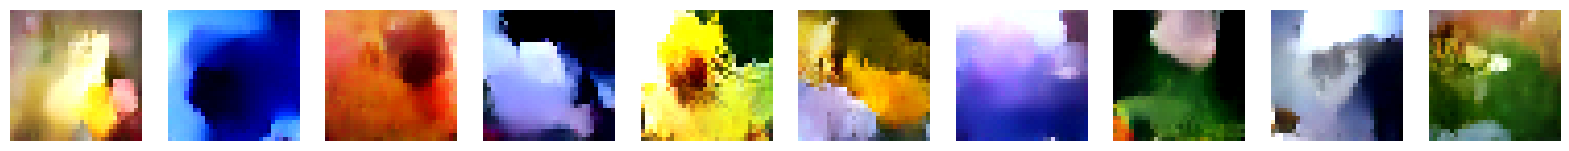

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - n_loss: 0.2360
Epoch 6/20
3666/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2357
Saved to /content/output/generated_img_005.png


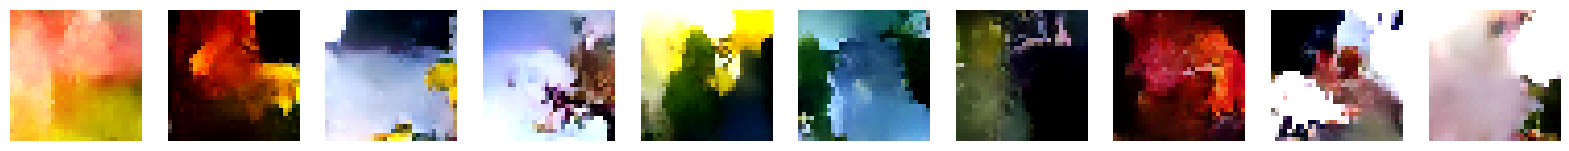

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2357
Epoch 7/20
3666/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2344
Saved to /content/output/generated_img_006.png


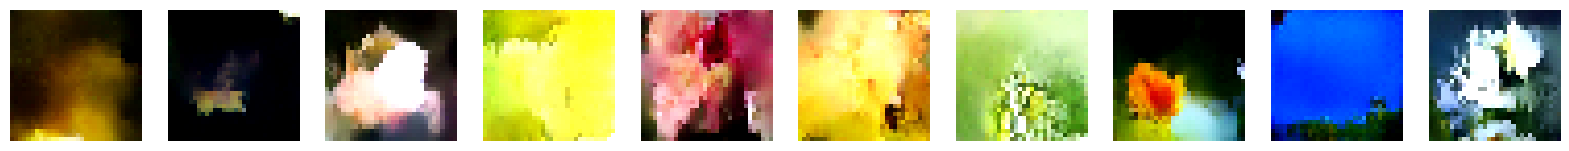

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2344
Epoch 8/20
3667/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2328
Saved to /content/output/generated_img_007.png


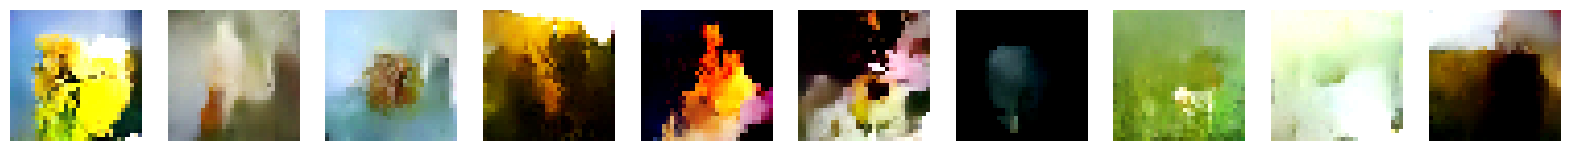

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - n_loss: 0.2328
Epoch 9/20
3668/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2300
Saved to /content/output/generated_img_008.png


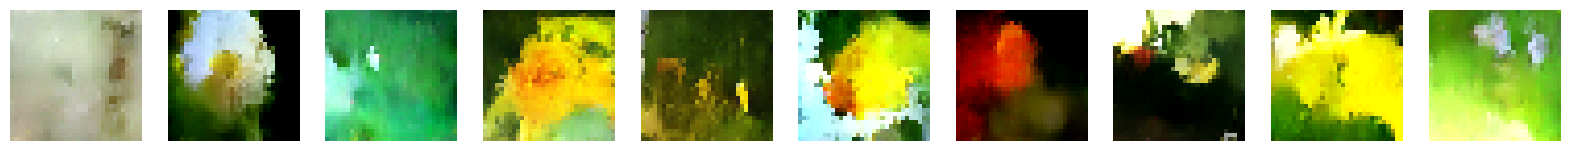

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - n_loss: 0.2300
Epoch 10/20
3667/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2296
Saved to /content/output/generated_img_009.png


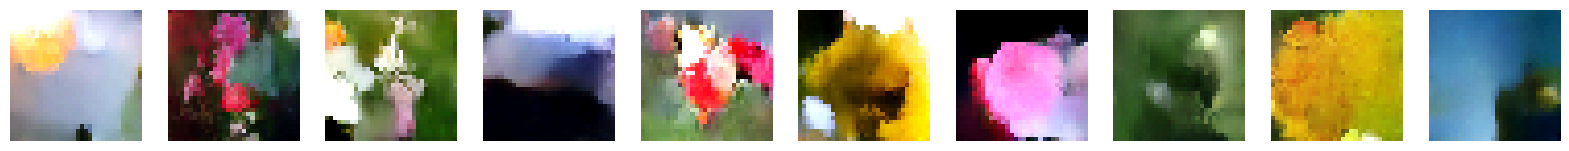

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2296
Epoch 11/20
3667/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2291
Saved to /content/output/generated_img_010.png


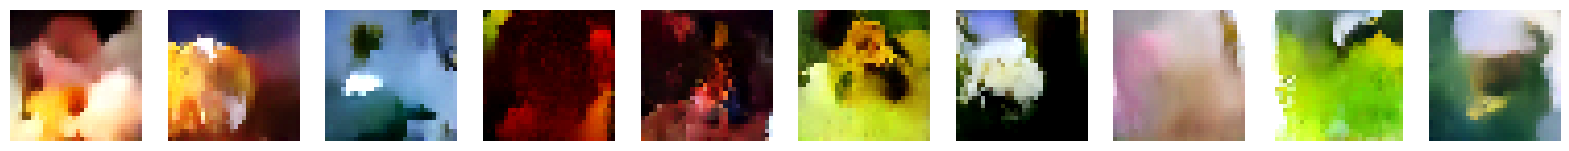

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2291
Epoch 12/20
3668/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2267
Saved to /content/output/generated_img_011.png


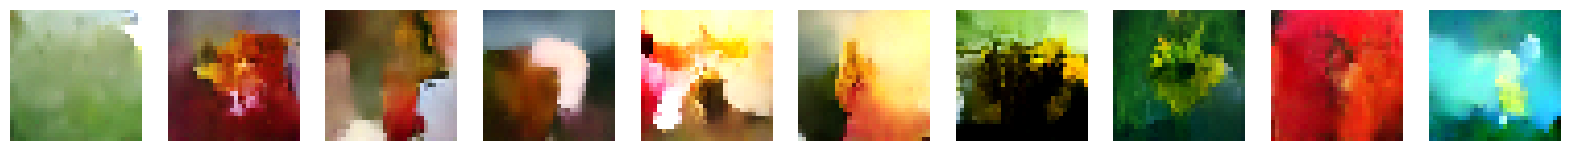

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2267
Epoch 13/20
3668/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2298
Saved to /content/output/generated_img_012.png


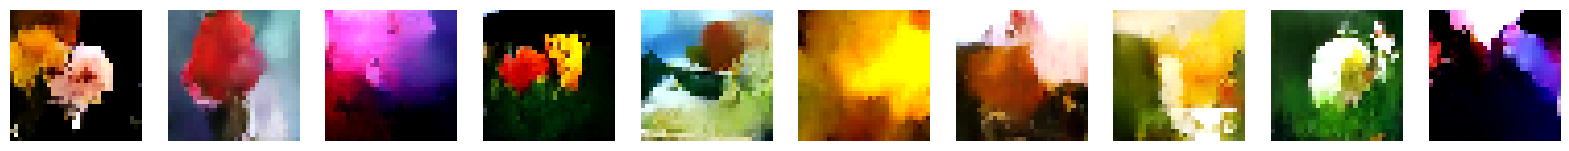

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2298
Epoch 14/20
3670/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2285
Saved to /content/output/generated_img_013.png


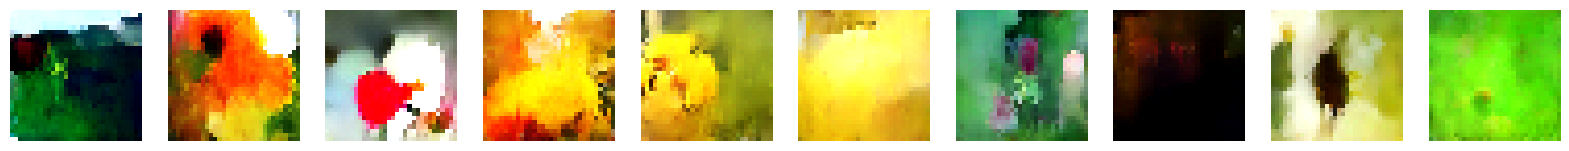

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - n_loss: 0.2285
Epoch 15/20
3667/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2276
Saved to /content/output/generated_img_014.png


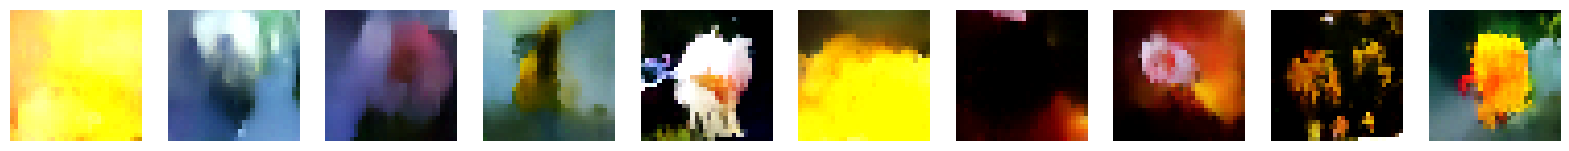

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - n_loss: 0.2276
Epoch 16/20
3667/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2272
Saved to /content/output/generated_img_015.png


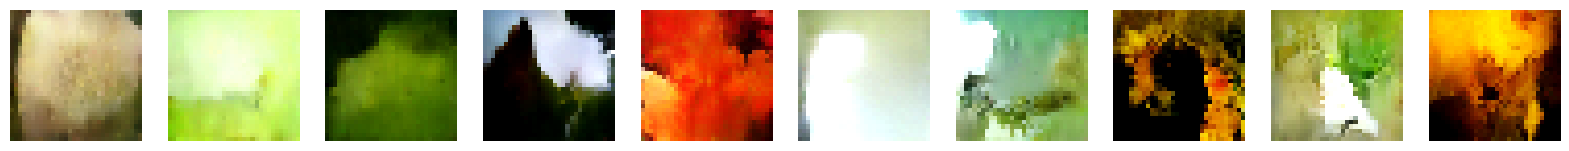

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - n_loss: 0.2272
Epoch 17/20
3668/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2281
Saved to /content/output/generated_img_016.png


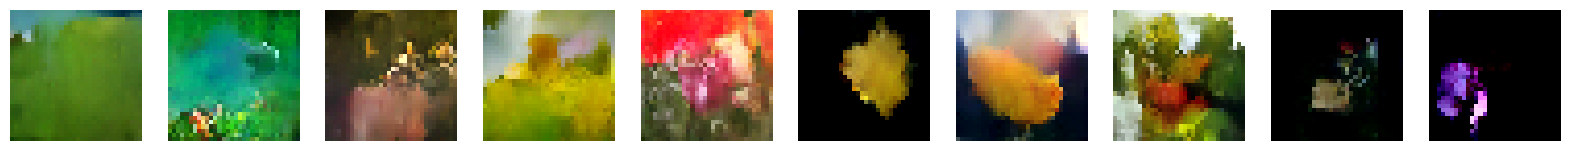

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - n_loss: 0.2281
Epoch 18/20
3669/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2265
Saved to /content/output/generated_img_017.png


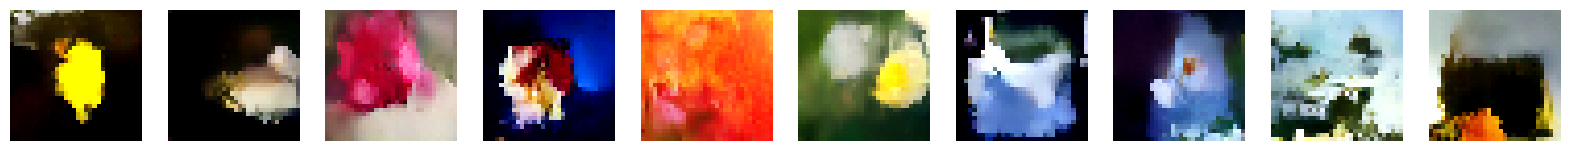

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2265
Epoch 19/20
3670/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2247
Saved to /content/output/generated_img_018.png


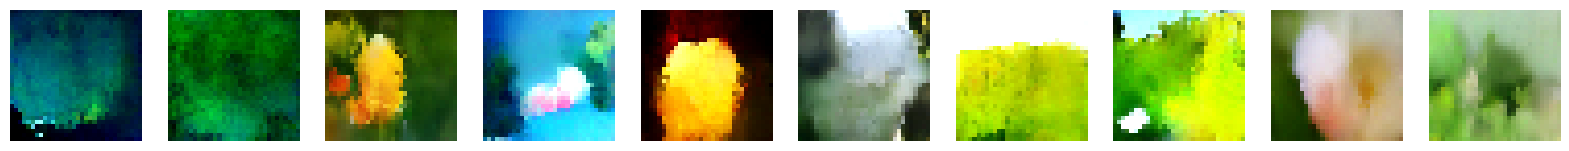

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2247
Epoch 20/20
3670/3670 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - n_loss: 0.2228
Saved to /content/output/generated_img_019.png


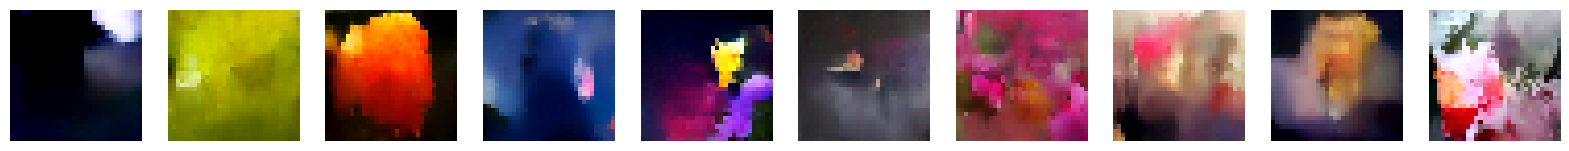

3670/3670 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - n_loss: 0.2228


In [31]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generate(
            num_images=self.num_img,
            diffusion_steps=PLOT_DIFFUSION_STEPS,
        ).numpy()
        display(
            generated_images,
            save_to="/content/output/generated_img_%03d.png" % (epoch),
        )


image_generator_callback = ImageGenerator(num_img=10)

ddm.build(input_shape=(None, 28, 28, 1))

ddm.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

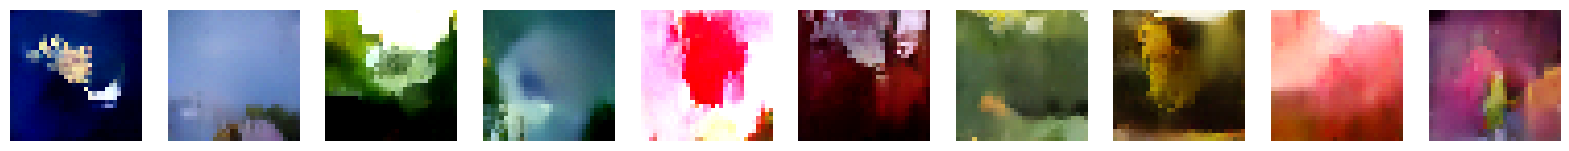

In [32]:
generated_images = ddm.generate(num_images=10, diffusion_steps=20).numpy()
display(generated_images)

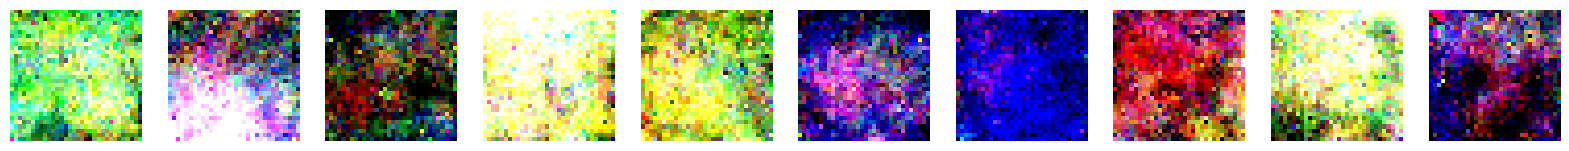

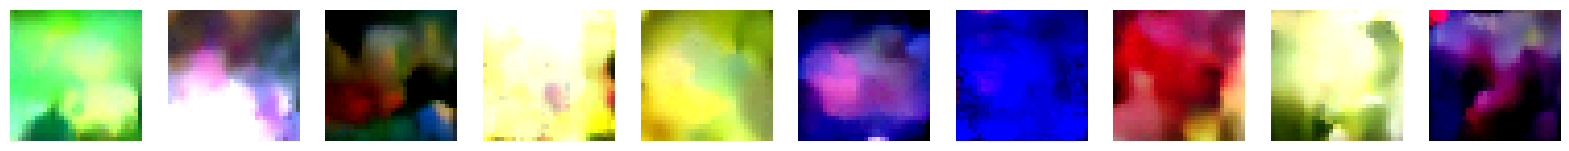

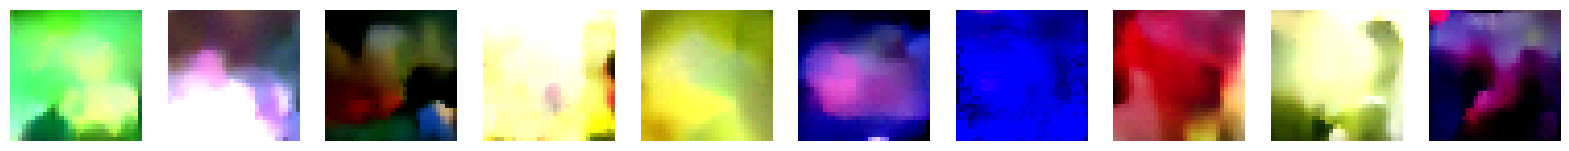

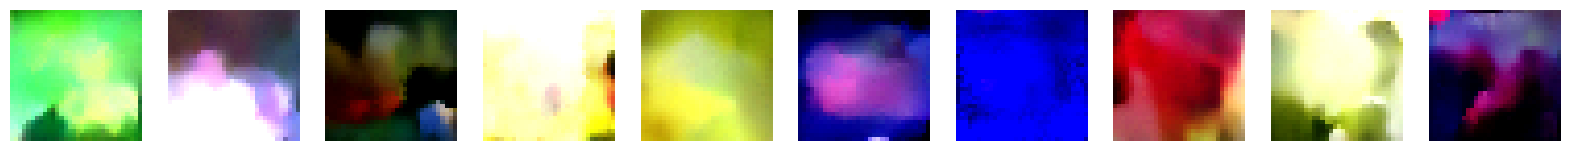

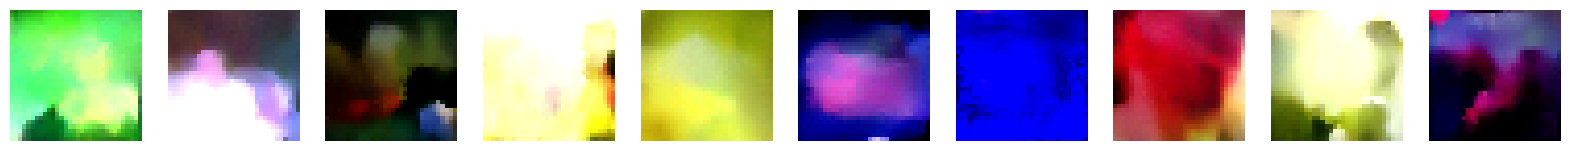

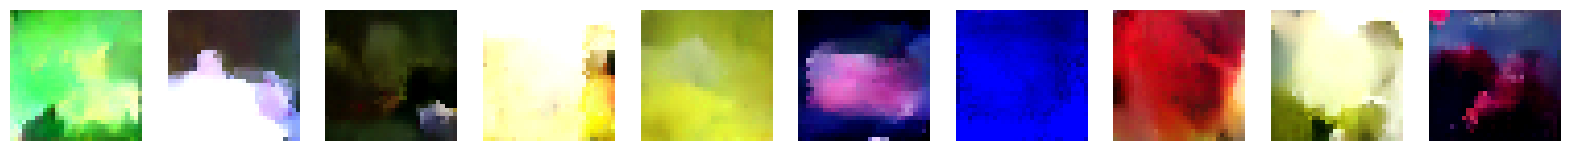

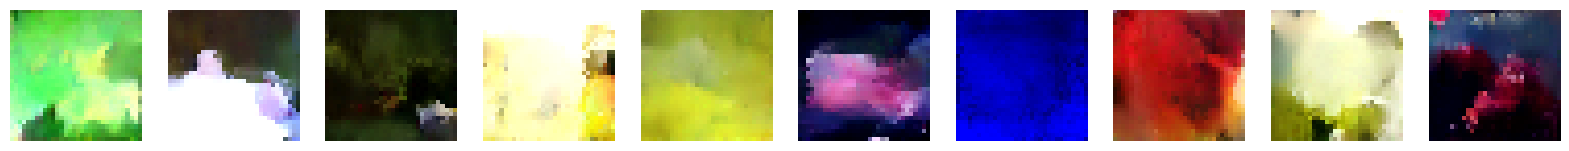

In [33]:
for diffusion_steps in list(np.arange(1, 6, 1)) + [20] + [100]:
    tf.random.set_seed(42)
    generated_images = ddm.generate(
        num_images=10,
        diffusion_steps=diffusion_steps,
    ).numpy()
    display(generated_images)

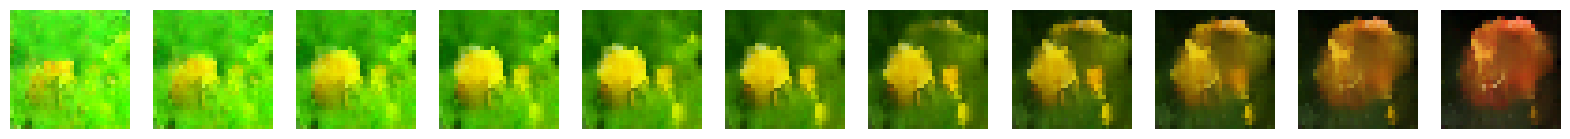

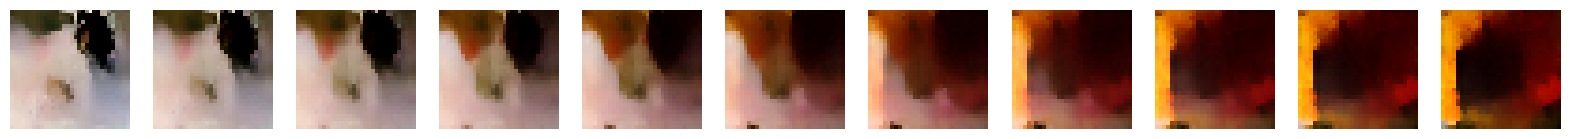

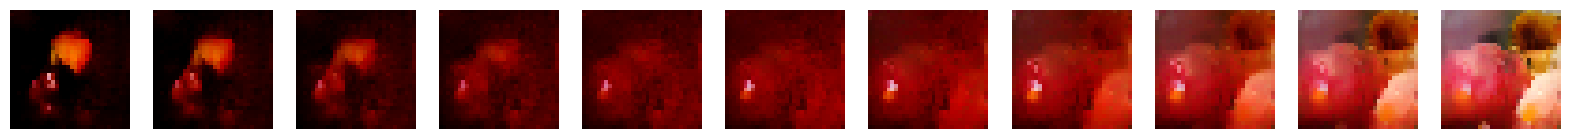

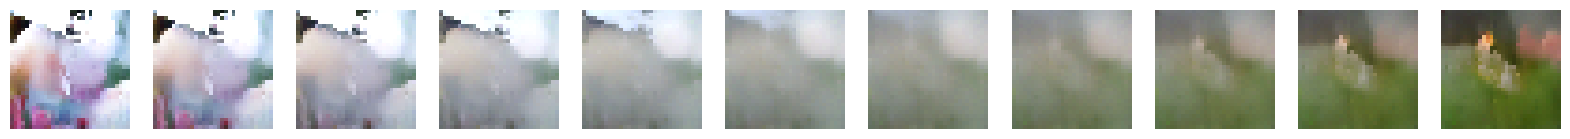

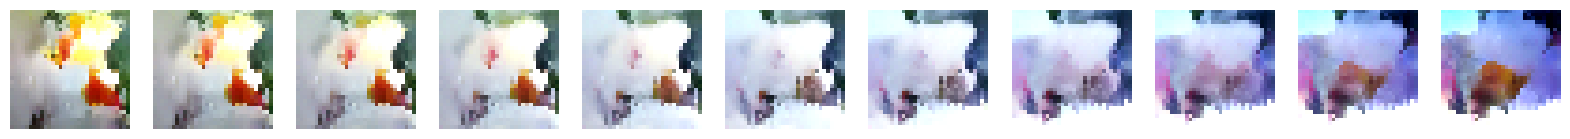

In [34]:
def spherical_interpolation(a, b, t):
    t = tf.cast(t, tf.float32)
    return tf.math.sin(t * math.pi / 2) * a + tf.math.cos(t * math.pi / 2) * b

for i in range(5):
    a = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32) # Explicitly set dtype to tf.float32
    b = tf.random.normal(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float32) # Explicitly set dtype to tf.float32
    initial_noise = tf.convert_to_tensor(
        [spherical_interpolation(a, b, t) for t in np.arange(0, 1.1, 0.1)]
    )
    generated_images = ddm.generate(
        num_images=2, diffusion_steps=20, initial_noise=tf.cast(initial_noise, tf.float32)
    ).numpy()
    display(generated_images, n=11)